In [226]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly_resampler import register_plotly_resampler, FigureResampler, FigureWidgetResampler
from plotly.subplots import make_subplots
from scipy.signal import find_peaks, savgol_filter, oaconvolve, detrend, windows
from scipy.fft import fft, fftfreq, ifft
import matplotlib.pyplot as plt
import ruptures as rpt

register_plotly_resampler(mode='auto')

In [260]:
jbzq04_force_1= pd.read_csv('C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/JBZQ04/JBZQ04-exp1-2023-06-16-kn.csv', header=1, 
                    names=['time', 'x_force', 'y_force'], usecols=[0,1,2])
jbzq04_dataframe_1 = pd.read_csv('C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/JBZQ04/JBZQ04-exp1-2023-06-16-mm.csv', header=1, 
                           names=['time', 'x_disp', 'y_disp', 'y_motor_disp', 'x_motor_disp'], usecols=[0,1,2,3,4])

# add x_force and y_force to the main dataframe
jbzq04_dataframe_1['x_force'] = jbzq04_force_1['x_force']
jbzq04_dataframe_1['y_force'] = jbzq04_force_1['y_force']

rough_force_1= pd.read_csv('C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/countertops/JAB_BlackSmoothOnSmooth(kN).csv', header=1, 
                    names=['time', 'x_force', 'y_force'], usecols=[0,1,2])
rough_dataframe_1 = pd.read_csv('C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/countertops/JAB_BlackSmoothOnSmooth(mm).csv', header=1, 
                           names=['time', 'x_disp', 'y_disp', 'y_motor_disp', 'x_motor_disp'], usecols=[0,1,2,3,4])

# add x_force and y_force to the main dataframe
rough_dataframe_1['x_force'] = rough_force_1['x_force']
rough_dataframe_1['y_force'] = rough_force_1['y_force']


# jbzq04_force_2 = pd.read_csv('C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/JBZQ04/JBZQ04-exp2-2023-07-21-kn.csv', header=1, 
#                       names=['time', 'x_force', 'y_force'], usecols=[0,1,2])
# jbzq04_displacement_2 = pd.read_csv('C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/JBZQ04/JBZQ04-exp2-2023-07-21-mm.csv', header=1, 
#                              names=['time', 'x_disp', 'y_disp', 'y_motor_disp', 'x_motor_disp'], usecols=[0,1,2,3,4])


# sm1_force = pd.read_csv('C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/SM1/JAB_SM1v2_071723(kN).csv', header=1, 
#                         names=['time', 'x_force', 'y_force'], usecols=[0,1,2])
# sm1_displacement = pd.read_csv('C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/SM1/JAB_SM1v2_071723(mm).csv', header=1, 
#                                 names=['time', 'x_disp', 'y_disp', 'y_motor_disp', 'x_motor_disp'], usecols=[0,1,2,3,4])

# avly02_force = pd.read_csv('C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/AVLY02/AVLY02-2023-07-12-kn.csv', header=1, 
#                     names=['time', 'x_force', 'y_force'], usecols=[0,1,2])
# avly02_displacement = pd.read_csv('C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/AVLY02/AVLY02-2023-07-12-mm.csv', header=1, 
#                              names=['time', 'x_disp', 'y_disp', 'y_motor_disp', 'x_motor_disp'], usecols=[0,1,2,3,4])

# flat_force = pd.read_csv('C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/old_flat/cameraTest_smoothsmooth(kN).csv', header=1,
#                             names=['time', 'x_force', 'y_force'], usecols=[0,1,2])
# flat_displacement = pd.read_csv('C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/old_flat/cameraTest_smoothsmooth(mm).csv', header=1,
#                             names=['time', 'x_disp', 'y_disp', 'y_motor_disp', 'x_motor_disp'], usecols=[0,1,2,3,4])

In [ ]:
# convert distances in sm1 from microns to mm
force_sm1['x_motor_disp'] = force_sm1['x_motor_disp'] / 1000
force_sm1['x_disp'] = force_sm1['x_disp'] / 1000

displacement_sm1['x_motor_disp'] = displacement_sm1['x_motor_disp'] / 1000
displacement_sm1['x_disp'] = displacement_sm1['x_disp'] / 1000
displacement_sm1['y_disp'] = displacement_sm1['y_disp'] / 1000
displacement_sm1['y_motor_disp'] = displacement_sm1['y_motor_disp'] / 1000

In [84]:
def fft_plot(data):
    
    # Number of points
    N = data.shape[0]

    # Sampling rate (# points / range of values, in points/distance)
    sampling_rate = N / (data.max(axis=0)['x_disp'] - data.min(axis=0)['x_disp'])
    T = 1 / sampling_rate # Sampling period

    # FFT of the raw friction data
    friction_fft = fft(data['friction'].values)

    # Frequencies of the FFT
    friction_fft_freq = fftfreq(N, T)

    # Filtering high frequencies and very low frequencies from the FFT
    friction_fft[np.where(np.logical_and(abs(friction_fft_freq)>=400, abs(friction_fft_freq)<=5000))] = 0
    # friction_fft[np.where(np.logical_and(abs(friction_fft_freq)>=2.45, abs(friction_fft_freq)<=2.5))] = 0

    # Inverse FFT to return smoothed signal to the time domain
    inverse_friction = ifft(friction_fft)

    # Applying Hann window to the smoothed (inversed) signal to kill edge artifacts (tapering)
    # inverse_friction = windows.tukey(len(inverse_friction), 0.05) * inverse_friction

    # Setting 'friction' column in dataframe to the smoothed signal
    data['friction'] = inverse_friction

    # plt.plot(np.arange(0, N), inverse_friction * 100)
    # plt.plot(friction_fft_freq, abs(friction_fft))
    # plt.ylim(-0.3, 0.3)
    # plt.xlim(0, 20)
    # plt.grid()
    # plt.show()

    return data

In [254]:
def add_cols(dataframe):

    # Add friction (F / x = k)
    dataframe['friction'] = -dataframe['x_force'] / dataframe['y_force']

    # Cropping data so friction is between 0 and 1
    dataframe = dataframe[dataframe['friction'] > 0]

    dataframe = dataframe[dataframe['friction'] < 1]

    # Mean velocity
    dataframe['x_speed'] = np.gradient(dataframe['x_motor_disp'], dataframe['time'])
    # displacement['x_speed'] = displacement['x_speed'].rolling(2000).mean()
    dataframe['x_speed'] = dataframe['x_speed'].rolling(200).median()

    # Rate of change of friction wrt displacement
    dataframe['friction_slope'] = np.gradient(dataframe['friction'], dataframe['x_motor_disp'])

    return dataframe

def find_stress_drops(dataframe, window_size, stddev_coef):

    dataframe['troughs'] = False
    dataframe['peaks'] = False
    dataframe['friction_drop'] = 0

    # Loading the friction (stress drops = inverted peaks)
    friction = dataframe['friction']
    friction_slope = dataframe['friction_slope']

    """BELOW HERE IS THE NEW STRESS DROP DETECTION ALGORITHM, BASED ON RUPTURES PACKAGE"""
    # x_disp = dataframe['x_disp'].to_numpy()
    # algo = rpt.Pelt(model="rbf").fit(x_disp)
    # troughs = algo.predict(pen=20)

    # troughs.pop(-1)
    # print(troughs)
    """ABOVE HERE IS THE NEW STRESS DROP DETECTION ALGORITHM, BASED ON RUPTURES PACKAGE"""

    """BELOW HERE IS THE OLD STRESS DROP DETECTION ALGORITHM, BASED ON FIRST DIFFERENCE OF FRICTION"""

    # Normalizing the inverted friction
    friction_slope = (friction_slope - np.min(friction_slope))/(np.max(friction_slope) - np.min(friction_slope))
    friction = (friction - np.min(friction))/(np.max(friction) - np.min(friction))

    # Detect peaks of a certain prominence, and minimum distance from each other
    troughs, _ = find_peaks(-1*friction_slope, distance=20, prominence=0.1) # threshold=30, prominence=120

    # Calculate the standard dev of the friction slope data
    stddev = np.std(friction_slope)
    mean = np.mean(friction_slope)

    # Convert friction slope to numpy array
    friction_slope = friction_slope.to_numpy()
    friction = friction.to_numpy()

    # filter troughs < 'stddev_coef' std from mean, take initial length of list to calculate drop %
    pre_len = len(troughs)
    troughs = [trough for trough in troughs if abs(friction_slope[trough] - mean) > stddev_coef*stddev]

    """ABOVE HERE IS THE OLD STRESS DROP DETECTION ALGORITHM, BASED ON FIRST DIFFERENCE OF FRICTION"""

    # For each index in peaks, check to see if there is a lower friction value in the last 15 samples (false pick)
    # Then search indices surrounding the peak pick to see if there are lower values (true drop)
    for trough in troughs:
        if trough >= 15: # Above index of 15, to solve any indexing issues. Introduces error as nothing i<15 will be affected
            if np.min(friction[trough-15:trough]) < friction[trough]: # Check for lower friction value in i-15
                troughs.remove(trough)

        # Checks friction values locally to find true stress drop trough
        if troughs != [] and trough in troughs and trough >= 3 and trough <= window_size - 4:
            # If the pick is too far forward (+ X +/-)
            # This deals with the flat case too (moved the stress drop to the left as far as possible)
            while friction[trough] - friction[trough - 1] >= 0 and friction[trough] - friction[trough + 1] <= 0:
                troughs.remove(trough) # Removing peak in peaks list
                trough = trough - 1 # Replacing peak with peak - 1
                troughs.append(trough) # Replacing peak value in peaks list (with peak - 1)
            print(trough, friction[trough], friction[trough - 1], friction[trough + 1])
            while friction[trough] - friction[trough + 1] >= 0 and trough < window_size - 1:
                troughs.remove(trough) # Removing peak in peaks list
                trough = trough + 1 # Replacing peak with peak - 1
                troughs.append(trough) # Replacing peak value in peaks list (with peak - 1)

    # Iterate over each peak and look for the maximum friction value in the last 5 indices to find
    # the stress "peak" preceding the drop
    peaks = troughs.copy()

    for peak in peaks:
        if peaks!= [] and peak >= 5: # Only look at peaks above i=5, to solve any indexing issues (also check for empty list)
            while friction[peak] - friction[peak - 1] <= 0: # While the previous point's friction value is higher
                peaks.remove(peak) # Remove the current value, replace with the point before it
                peak = peak - 1
                peaks.append(peak)

    # Calculate the friction drop between each peak/trough pair
    friction = dataframe['friction'].to_numpy() # redifine so it's not normalized

    friction_drops = []

    for peak, trough in zip(peaks, troughs):    

        if peak == trough or friction[peak] - friction[trough] <= 0:
            peaks.remove(peak)
            troughs.remove(trough)
            continue

        else:
            friction_drops.append(friction[peak] - friction[trough])

    # print dropped # of peaks
    post_len = len(troughs)
    drop_count = pre_len - post_len
    print(f'Dopped {drop_count} picks')

    # plt.plot(np.arange(0, len(friction_slope)), friction_slope)
    # plt.plot(np.arange(0, len(friction)), friction)
    # plt.scatter(peaks, friction[peaks])
    # plt.axhline(stddev_coef*stddev + mean)
    # plt.axhline(-stddev_coef*stddev + mean)
    # plt.show()

    # dataframe['peaks'].iloc[peaks] = True

    # stress_drops = dataframe.loc[force['peaks'] == True]

    return peaks, troughs, friction_drops

def add_stress_drops(dataframe, window_size, stddev_coef):

    # List of True/False values that will be turned into a df (force) column, where 
    peak_list = []
    trough_list = []
    friction_drop_list = []

    # Dividing the df into chunks of window_size
    for chunk in np.array_split(dataframe, len(dataframe) // window_size + 1):
        
        # Chunk-length list of Falses
        peak_temp_list = np.full(len(chunk), False)
        trough_temp_list = np.full(len(chunk), False)
        friction_drop_temp_list = list(np.full(len(chunk), 0))
        
        # Find peaks
        peaks, troughs, friction_drops = find_stress_drops(chunk, window_size, stddev_coef)

        # Replace False temp_lists with True where peaks are
        peak_temp_list[peaks] = True
        trough_temp_list[troughs] = True

        for trough, friction_drop in zip(troughs, friction_drops):
           friction_drop_temp_list[trough] = friction_drop

        # Adding the temp_lists to the main _lists
        peak_list = peak_list + list(peak_temp_list)
        trough_list = trough_list + list(trough_temp_list)
        friction_drop_list = friction_drop_list + list(friction_drop_temp_list)
        
        print(f'{len(trough_list)} / {len(dataframe)}')

    dataframe['peaks'] = peak_list
    dataframe['troughs'] = trough_list
    dataframe['friction_drops'] = friction_drop_list

    # stress_drops = force.loc[force['troughs'] == True]

    return dataframe

def pick_velocity(stated_velocity):
    stated_velocity = float(stated_velocity)

    low = stated_velocity - stated_velocity*0.1
    high = stated_velocity + stated_velocity*0.1
    return low, high

In [250]:
# JBZQ04 1
jbzq04_dataframe_1 = add_cols(jbzq04_dataframe_1)

jbzq04_dataframe_1 = add_stress_drops(jbzq04_dataframe_1, 320, 3)

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning:

divide by zero encountered in divide

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning:

invalid value encountered in divide

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1243: RuntimeWarning:

divide by zero encountered in divide

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1243: RuntimeWarning:

invalid value encountered in divide

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1244: RuntimeWarning:

divide by zero encountered in divide

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\functi

Dopped 3 picks
320 / 3603614
Dopped 2 picks
640 / 3603614
Dopped 3 picks
960 / 3603614
Dopped 0 picks
1280 / 3603614
Dopped 0 picks
1600 / 3603614
Dopped 0 picks
1920 / 3603614
Dopped 0 picks
2240 / 3603614
Dopped 0 picks
2560 / 3603614
Dopped 0 picks
2880 / 3603614
Dopped 0 picks
3200 / 3603614
Dopped 0 picks
3520 / 3603614
Dopped 0 picks
3840 / 3603614
Dopped 0 picks
4160 / 3603614
Dopped 0 picks
4480 / 3603614
Dopped 0 picks
4800 / 3603614
Dopped 0 picks
5120 / 3603614
Dopped 0 picks
5440 / 3603614
Dopped 0 picks
5760 / 3603614
Dopped 0 picks
6080 / 3603614
Dopped 0 picks
6400 / 3603614
Dopped 0 picks
6720 / 3603614
Dopped 0 picks
7040 / 3603614
Dopped 0 picks
7360 / 3603614
Dopped 0 picks
7680 / 3603614
Dopped 0 picks
8000 / 3603614
Dopped 0 picks
8320 / 3603614
Dopped 0 picks
8640 / 3603614
Dopped 0 picks
8960 / 3603614
Dopped 0 picks
9280 / 3603614
Dopped 0 picks
9600 / 3603614
Dopped 0 picks
9920 / 3603614
Dopped 0 picks
10240 / 3603614
Dopped 0 picks
10560 / 3603614
Dopped 0 pi

C:\Users\stickslip\AppData\Local\Temp\ipykernel_15768\2129404316.py:43: RuntimeWarning:

invalid value encountered in scalar subtract



In [93]:
# JBZQ04 2
jbzq04_force_2, jbzq04_displacement_2 = add_cols(jbzq04_force_2, jbzq04_displacement_2)

jbzq04_force_2 = add_stress_drops(jbzq04_force_2, 1000, 1.5)

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning:

divide by zero encountered in divide

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning:

invalid value encountered in divide

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1243: RuntimeWarning:

divide by zero encountered in divide

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1243: RuntimeWarning:

invalid value encountered in divide

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1244: RuntimeWarning:

divide by zero encountered in divide

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\functi

Dopped 0 picks
1000 / 4044430
Dopped 0 picks
2000 / 4044430
Dopped 0 picks
3000 / 4044430
Dopped 0 picks
4000 / 4044430
Dopped 0 picks
5000 / 4044430
Dopped 0 picks
6000 / 4044430
Dopped 0 picks
7000 / 4044430
Dopped 0 picks
8000 / 4044430
Dopped 0 picks
9000 / 4044430
Dopped 0 picks
10000 / 4044430
Dopped 0 picks
11000 / 4044430
Dopped 0 picks
12000 / 4044430
Dopped 0 picks
13000 / 4044430
Dopped 0 picks
14000 / 4044430
Dopped 0 picks
15000 / 4044430
Dopped 0 picks
16000 / 4044430
Dopped 0 picks
17000 / 4044430
Dopped 0 picks
18000 / 4044430
Dopped 0 picks
19000 / 4044430
Dopped 0 picks
20000 / 4044430
Dopped 0 picks
21000 / 4044430
Dopped 0 picks
22000 / 4044430
Dopped 0 picks
23000 / 4044430
Dopped 0 picks
24000 / 4044430
Dopped 0 picks
25000 / 4044430
Dopped 0 picks
26000 / 4044430
Dopped 0 picks
27000 / 4044430
Dopped 0 picks
28000 / 4044430
Dopped 0 picks
29000 / 4044430
Dopped 0 picks
30000 / 4044430
Dopped 0 picks
31000 / 4044430
Dopped 0 picks
32000 / 4044430
Dopped 0 picks
33

C:\Users\stickslip\AppData\Local\Temp\ipykernel_15768\1763454.py:40: RuntimeWarning:

invalid value encountered in scalar subtract



Dopped 0 picks
4044430 / 4044430


In [ ]:
#SM1 v2
sm1_force, sm1_displacement = add_cols(sm1_force, sm1_displacement)

# sm1_stress_drops = add_stress_drops(sm1_force, 1000, 4)

In [ ]:
# AVLY02
avly02_force, avly02_displacement = add_cols(avly02_force, avly02_displacement)

# avly02_stress_drops = add_stress_drops(avly02_force, 1000, 4)

In [5]:
flat_force, flat_displacement = add_cols(flat_force, flat_displacement)


c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: invalid value encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1243: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1244: RuntimeWarning: divide by zero encounter

In [6]:
# Flat

flat_force = add_stress_drops(flat_force, 1000, 2.5)

409 0.3782372020414018 0.57546432932912 0.2413225165599736
Dopped 32 picks
1000 / 1700426
Dopped 34 picks
2000 / 1700426
3 0.34747956893626747 0.4476207529955757 0.08607787241524201
Dopped 34 picks
3000 / 1700426
Dopped 33 picks
4000 / 1700426
616 0.31323479637656926 0.617195232166526 0.1849203897694803
Dopped 32 picks
5000 / 1700426
Dopped 37 picks
6000 / 1700426
821 0.36680018362719075 0.613208060829383 0.15061320884456217
822 0.15061320884456217 0.36680018362719075 0.2519833563057462
Dopped 33 picks
7000 / 1700426
468 0.17731065727059242 0.42061186854244514 0.0
Dopped 36 picks
8000 / 1700426
4 0.3093190819443444 0.5625863409461149 0.06982399052948737
5 0.06982399052948737 0.3093190819443444 0.249526412006349
Dopped 33 picks
9000 / 1700426
Dopped 35 picks
10000 / 1700426
Dopped 33 picks
11000 / 1700426
Dopped 35 picks
12000 / 1700426
656 0.43533150233227286 0.8464435850315738 0.24201894745397864
657 0.24201894745397864 0.43533150233227286 0.38943207334573243
Dopped 32 picks
13000 / 1

C:\Users\stickslip\AppData\Local\Temp\ipykernel_15768\1485524102.py:40: RuntimeWarning: invalid value encountered in scalar subtract
  friction_slope = (friction_slope - np.min(friction_slope))/(np.max(friction_slope) - np.min(friction_slope))


In [261]:
rough_dataframe_1 = add_cols(rough_dataframe_1)

rough_dataframe_1 = add_stress_drops(rough_dataframe_1, 1000, 3)

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning:

divide by zero encountered in divide

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning:

invalid value encountered in divide

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1243: RuntimeWarning:

divide by zero encountered in divide

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1243: RuntimeWarning:

invalid value encountered in divide

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1244: RuntimeWarning:

divide by zero encountered in divide

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\functi

Dopped 0 picks
1000 / 1074657
Dopped 0 picks
2000 / 1074657
Dopped 0 picks
3000 / 1074657
Dopped 0 picks
4000 / 1074657
Dopped 0 picks
5000 / 1074657
Dopped 0 picks
6000 / 1074657
Dopped 0 picks
7000 / 1074657
Dopped 0 picks
8000 / 1074657
Dopped 0 picks
9000 / 1074657
Dopped 0 picks
10000 / 1074657
Dopped 0 picks
11000 / 1074657
Dopped 0 picks
12000 / 1074657
Dopped 0 picks
13000 / 1074657
Dopped 0 picks
14000 / 1074657
Dopped 0 picks
15000 / 1074657
Dopped 0 picks
16000 / 1074657
Dopped 0 picks
17000 / 1074657
Dopped 0 picks
18000 / 1074657
Dopped 0 picks
19000 / 1074657
Dopped 0 picks
20000 / 1074657
Dopped 0 picks
21000 / 1074657
Dopped 0 picks
22000 / 1074657
Dopped 0 picks
23000 / 1074657
Dopped 0 picks
24000 / 1074657
Dopped 0 picks
25000 / 1074657
Dopped 0 picks
26000 / 1074657
Dopped 0 picks
27000 / 1074657
Dopped 0 picks
28000 / 1074657
Dopped 0 picks
29000 / 1074657
Dopped 0 picks
30000 / 1074657
Dopped 0 picks
31000 / 1074657
Dopped 0 picks
32000 / 1074657
Dopped 0 picks
33

C:\Users\stickslip\AppData\Local\Temp\ipykernel_15768\2129404316.py:43: RuntimeWarning:

invalid value encountered in scalar subtract



In [ ]:
lower = 13.924# 64.83# 29.16# 28.88#   25.6# # 
upper = 13.926# 64.93# 29.24# 28.98#   25.9# # 

subset_force = force[force['x_motor_disp'] < upper]
subset_force = subset_force[subset_force['x_motor_disp'] > lower]
subset_displacement = displacement[displacement['x_motor_disp'] < upper]
subset_displacement = subset_displacement[subset_displacement['x_motor_disp'] > lower]

stress_drops_new = find_stress_drops(subset_force, 100, 4)
stress_drops_fft = find_stress_drops(fft_plot(subset_force), 100, 4)
# fft_plot(subset_force)

In [262]:
# sort by column
sort_value = 'x_motor_disp'

# jbzq04_force_1 = jbzq04_force_1.sort_values(by=[sort_value])
jbzq04_dataframe_1 = jbzq04_dataframe_1.sort_values(by=[sort_value])

rough_dataframe_1 = rough_dataframe_1.sort_values(by=[sort_value])

# jbzq04_force_2 = jbzq04_force_2.sort_values(by=[sort_value])
# jbzq04_displacement_2 = jbzq04_displacement_2.sort_values(by=[sort_value])

# flat_force = flat_force.sort_values(by=[sort_value])
# flat_displacement = flat_displacement.sort_values(by=[sort_value])

# sm1_force = sm1_force.sort_values(by=[sort_value])
# sm1_displacement = sm1_displacement.sort_values(by=[sort_value])

# avly02_force = avly02_force.sort_values(by=[sort_value])
# avly02_displacement = avly02_displacement.sort_values(by=[sort_value])

# jbzq04_stress_drops_1 = jbzq04_stress_drops_1.sort_values(by=[sort_value])
# jbzq04_stress_drops_1 = jbzq04_stress_drops_1.drop_duplicates(subset=[sort_value])
# jbzq04_stress_drops_2 = jbzq04_stress_drops_2.sort_values(by=[sort_value])
# jbzq04_stress_drops_2 = jbzq04_stress_drops_2.drop_duplicates(subset=[sort_value])
# sm1_stress_drops = sm1_stress_drops.sort_values(by=[sort_value])
# sm1_stress_drops = sm1_stress_drops.drop_duplicates(subset=[sort_value])
# avly02_stress_drops = avly02_stress_drops.sort_values(by=[sort_value])
# avly02_stress_drops = avly02_stress_drops.drop_duplicates(subset=[sort_value])

# subset_force = subset_force.sort_values(by=[sort_value])
# subset_displacement = subset_displacement.sort_values(by=[sort_value])


In [263]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

# fig.add_trace(go.Scatter(x=jbzq04_dataframe_1['x_motor_disp'], y=jbzq04_dataframe_1['friction'], name='JBZQ04 1', connectgaps=True, mode='lines+markers'), secondary_y=False)

# fig.add_trace(go.Scatter(x=jbzq04_dataframe_1['x_motor_disp'].loc[jbzq04_dataframe_1['troughs'] == True], y=jbzq04_dataframe_1['friction'].loc[jbzq04_dataframe_1['troughs'] == True], 
#                          name='Peaks1', mode='markers'), secondary_y=False)

fig.add_trace(go.Scatter(x=rough_dataframe_1['x_motor_disp'], y=rough_dataframe_1['friction'], name='Rough 1', connectgaps=True, mode='lines+markers'), secondary_y=False)

fig.add_trace(go.Scatter(x=rough_dataframe_1['x_motor_disp'], y=rough_dataframe_1['x_speed'], name='Speed Rough 1', connectgaps=True, mode='lines+markers'), secondary_y=True)

fig.add_trace(go.Scatter(x=rough_dataframe_1['x_motor_disp'].loc[rough_dataframe_1['troughs'] == True], y=rough_dataframe_1['friction'].loc[rough_dataframe_1['troughs'] == True], 
                         name='Peaks1', mode='markers'), secondary_y=False)

# fig.add_trace(go.Scatter(x=jbzq04_force_1['x_motor_disp'].loc[jbzq04_force_1['troughs'] == True], y=jbzq04_force_1['friction_drops'].loc[jbzq04_force_1['troughs'] == True], 
#                          name='Stress drops 1', mode='markers'), secondary_y=False)

# fig.add_trace(go.Scatter(x=jbzq04_dataframe_1['x_motor_disp'], y=jbzq04_dataframe_1['x_speed'], name='JBZQ04 1 Speed', connectgaps=True, mode='lines+markers'), secondary_y=True)


# fig.add_trace(go.Scatter(x=jbzq04_force_2['x_motor_disp'], y=jbzq04_force_2['friction'], name='JBZQ04 2', connectgaps=True, mode='lines+markers'), secondary_y=False)

# fig.add_trace(go.Scatter(x=jbzq04_force_2['x_motor_disp'].loc[jbzq04_force_2['troughs'] == True], y=jbzq04_force_2['friction_drops'].loc[jbzq04_force_2['troughs'] == True], 
#                          name='Stress drops 1', mode='markers'), secondary_y=True)

# fig.add_trace(go.Scatter(x=jbzq04_force_2['x_motor_disp'].loc[jbzq04_force_2['troughs'] == True], y=jbzq04_force_2['friction'].loc[jbzq04_force_2['troughs'] == True], 
#                          name='Peaks1', mode='markers'), secondary_y=False)

# fig.add_trace(go.Scatter(x=jbzq04_displacement_2['x_motor_disp'], y=jbzq04_displacement_2['x_speed'], name='JBZQ04 2 Speed', connectgaps=True, mode='lines+markers'), secondary_y=True)


# fig.add_trace(go.Scatter(x=avly02_force[sort_value], y=avly02_force['friction'], name='AVLY02', connectgaps=True, mode='lines+markers'), secondary_y=False)

# fig.add_trace(go.Scatter(x=avly02_stress_drops[sort_value], y=avly02_stress_drops['friction'], name='Stress drops AVLY02', mode='markers'), secondary_y=False)

# fig.add_trace(go.Scatter(x=avly02_displacement['x_motor_disp'], y=avly02_displacement['x_speed'], name='AVLY02 Speed', connectgaps=True, mode='lines+markers'), secondary_y=True)

# plot flat data
# fig.add_trace(go.Scatter(x=flat_force[sort_value], y=flat_force['friction_slope'], name='Flat', connectgaps=True, mode='lines+markers'), secondary_y=False)

# fig.add_trace(go.Scatter(x=flat_force[sort_value], y=flat_force['y_force'], name='Flat Force', connectgaps=True, mode='lines+markers'), secondary_y=True)

# fig.add_trace(go.Scatter(x=flat_force[sort_value], y=flat_displacement['x_disp'], name='Flat ydisp', connectgaps=True, mode='lines+markers'), secondary_y=True)
# fig.add_trace(go.Scatter(x=flat_force[sort_value], y=flat_force['friction_drops'], name='Flat ydisp', connectgaps=True, mode='lines+markers'), secondary_y=True)

# fig.add_trace(go.Scatter(x=flat_force[sort_value].loc[flat_force['troughs'] == True], y=flat_force['friction'].loc[flat_force['troughs'] == True],
                            # name='Peaks Flat', mode='markers'), secondary_y=False)

# # add speed
# fig.add_trace(go.Scatter(x=flat_displacement['x_motor_disp'], y=flat_displacement['x_speed'], name='Flat Speed', connectgaps=True, mode='lines+markers'), secondary_y=True)



# Add steps as vertical lines
x_steps = np.array([2, 3, 4, 5, 8, 13])

t_steps = np.array([0, 100, 180, 230, 33, 360, 460, 520, 620, 740, 840, 1140, 1240, 1840, 2840, 3040, 3200, 3300, 3400, 3450, 3550, 3580, 3680, 3740, 3840, 3960, 4060, 4360, 4460, 5060, 5560])

# multiply by 50 to get time step
t_steps = t_steps + 162

fig.update_layout(width=1120, height=600, title='Friction vs. Displacement', xaxis_title='Displacement (mm)', yaxis_title='Friction Coefficient', font=dict(size=12))

fig


FigureWidgetResampler({
    'data': [{'connectgaps': True,
              'mode': 'lines+markers',
              'name': '<b style="color:sandybrown">[R]</b> Rough 1 <i style="color:#fc9944">~0.03</i>',
              'type': 'scatter',
              'uid': '59edd064-1db2-4366-8c94-8ea7a3d34b47',
              'x': array([-2.88309820e-07, -2.88309820e-07,  4.73247173e-02, ...,  3.22781570e+01,
                           3.23391214e+01,  3.23537134e+01]),
              'xaxis': 'x',
              'y': array([5.34636376e-01, 2.20880932e-05, 5.91918429e-03, ..., 4.87278829e-01,
                          4.88505394e-01, 4.86245398e-01]),
              'yaxis': 'y'},
             {'connectgaps': True,
              'mode': 'lines+markers',
              'name': ('<b style="color:sandybrown">[R' ... 'tyle="color:#fc9944">~0.03</i>'),
              'type': 'scatter',
              'uid': '9c5bf114-bd0b-473f-a715-e2c552311231',
              'x': array([-2.88309820e-07,  3.21997150e-02,  4.85215

### Comparison

JBZQ04 2, SM1, AVLY02
SHS, 0.1 mm/s
10-24 mm

#### Stress drops at 0.1 mm/s
- JBZQ04 1 (10 kN): 31-36 mm
- JBZQ04 2 (5 kN): 8-13 mm, 21-25 mm
- JBZQ04 2 (3 kN): 38-43 mm, 51-55 mm, 60-64 mm
- SM1 (2.5 kN): 7-12 mm, 20-28 mm
- AVLY02 (2.5 kN): 8-13 mm, 21-29 mm, 34-39 mm, 47-55 mm, 60-65 mm, 73-78 mm

#### Holds at 0.1 mm/s
- JBZQ04 2 (5 kN): 13-21 mm, [30, 60, 120, 300, 600]
- JBZQ04 2 (3 kN): 43-51 mm, [30, 60, 120, 300, 600]; 64-74 mm, [30, 60, 120, 300, 600, 1200]
- SM1 (2.5 kN): 12-20 mm, [10, 60, 120, 600, 1200]; 38-46 mm, [10, 60, 120, 600, 1200]; 64-72 mm, [10, 60, 120, 600, 1200]
- AVLY02 (2.5 kN): 13-21 mm, [30, 60, 120, 300, 600]; 39-47 mm, [30, 60, 120, 300, 600]; 65-73 mm, [30, 60, 120, 300, 600]


In [113]:
# Make a new df from jbzq01_force_1, with only the stress drops
jbzq04_stress_drops_1 = jbzq04_force_1.loc[jbzq04_force_1['troughs'] == True]
# Drop stress drops that are too small
jbzq04_stress_drops_1 = jbzq04_stress_drops_1[jbzq04_stress_drops_1['friction_drops'] > 0.01]

# make new df for flat surfaces
flat_stress_drops = flat_force.loc[flat_force['troughs'] == True]
# drop stress drops that are too small
flat_stress_drops = flat_stress_drops[flat_stress_drops['friction_drops'] > 0.01]

# make df for jbzq04 2
jbzq04_stress_drops_2 = jbzq04_force_2.loc[jbzq04_force_2['troughs'] == True]
# drop stress drops that are too small
jbzq04_stress_drops_2 = jbzq04_stress_drops_2[jbzq04_stress_drops_2['friction_drops'] > 0.001]

In [199]:
def plot_histogram(dataframe, variable, diff, speeds, nbins):
    """ 
    INPUTS:
    dataframe: DataFrame containing the data to be plotted
    variable: String of the variable to be plotted
    diff: Boolean, whether or not to take the first difference of the variable
    speeds: List of the speeds to be plotted
    nbins: Number of bins in the histogram
    """

    # Automatically calculate the range of the histograms by
    # setting it to include 90% of the data
    max_value = 0
    for speed in speeds:
        
        print(np.mean(dataframe['y_force'].loc[dataframe['x_speed'].between(*pick_velocity(speed))]))
        
        # Checking if empty
        if len(dataframe[variable].loc[dataframe['x_speed'].between(*pick_velocity(speed))]) != 0:      

            # find the range between 0 and x that includes 93% of the data
            if diff == True:
                upper = np.percentile(np.diff(dataframe[variable].loc[dataframe['x_speed'].between(*pick_velocity(speed))]), 93)
            else:
                upper = np.percentile(dataframe[variable].loc[dataframe['x_speed'].between(*pick_velocity(speed))], 93)
                
            # Replacing max_value if the upper value is greater (extending range of histograms to accomodate "spreadiest" data)
            if upper > max_value:
                max_value = upper
    
    # Plot the histograms on the same figure as different axis
    fig, ax = plt.subplots()

    for speed in speeds:
        if diff == True:
            ax.hist(np.diff(dataframe[variable].loc[dataframe['x_speed'].between(*pick_velocity(speed))]), bins=nbins, alpha=0.5, range=(0, max_value), label=f'{speed} mm/s')
        else:
            ax.hist(dataframe[variable].loc[dataframe['x_speed'].between(*pick_velocity(speed))], bins=nbins, alpha=0.5, range=(0, max_value), label=f'{speed} mm/s')

    ax.set_xlabel(f'{variable}')
    ax.set_ylabel('Frequency')
    ax.legend()
    plt.show()


nan
9.792716895793134
9.840342635942944
9.783507211850726
9.740060193032726


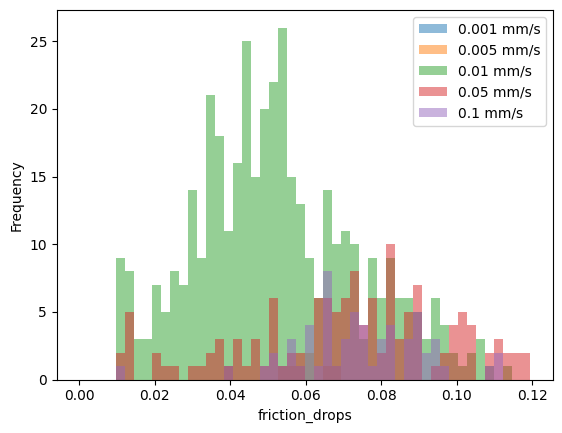

16.783514465704727
14.88152878300653
19.830966273951564


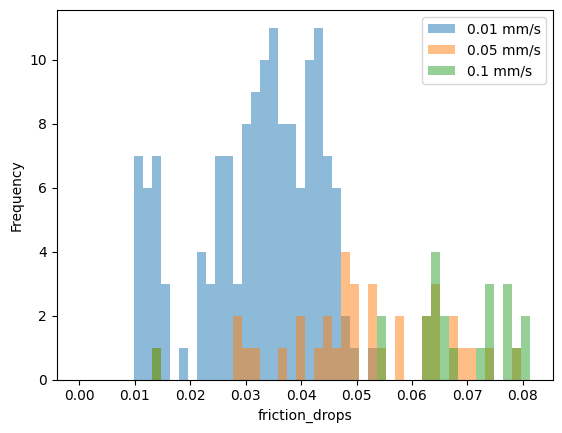

nan
3.68320262227298
4.13826159901472
3.7617883017402245
3.5530581553278733
4.957975516252908


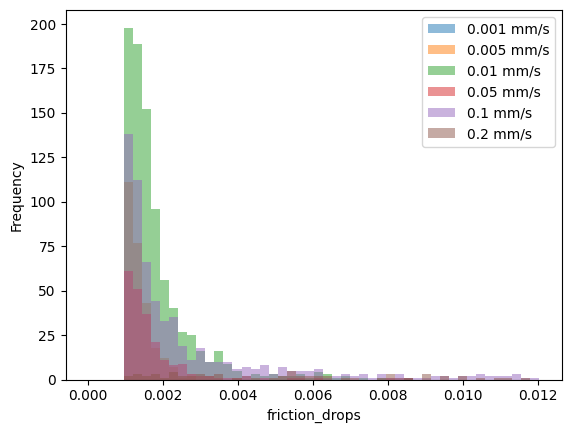

In [200]:
nbins = 50

plot_histogram(jbzq04_stress_drops_1, 'friction_drops', False, [0.001, 0.005, 0.01, 0.05, 0.1], nbins)

plot_histogram(flat_stress_drops, 'friction_drops', False, [0.01, 0.05, 0.1], nbins)

plot_histogram(jbzq04_stress_drops_2, 'friction_drops', False, [0.001, 0.005, 0.01, 0.05, 0.1, 0.2], nbins)

#### Time interval

9.792716895793134
9.840342635942944
9.783507211850726
9.740060193032726


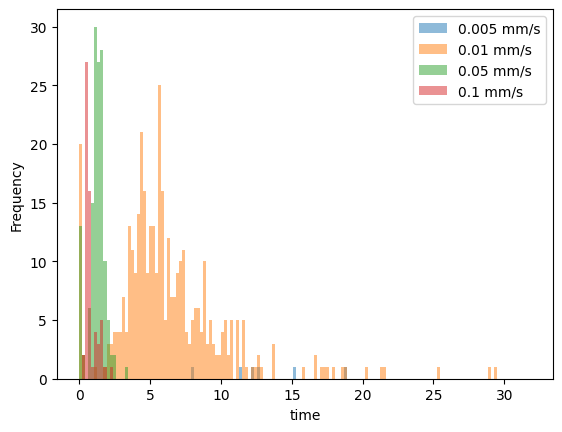

16.783514465704727
14.88152878300653
19.830966273951564


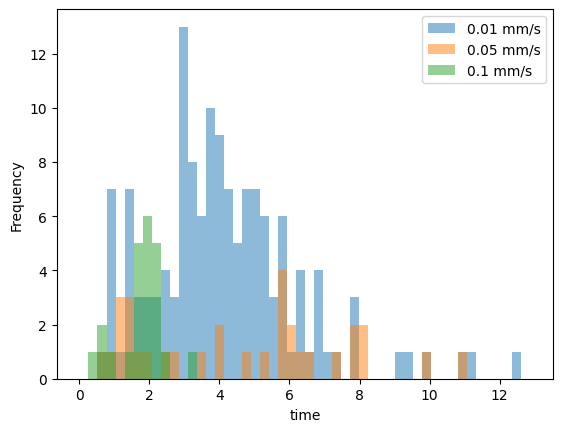

In [204]:
# At each velocity, plot the time between stress drops in a histogram (matplotlib)
plot_histogram(jbzq04_stress_drops_1, 'time', True, [0.005, 0.01, 0.05, 0.1], nbins+100)

plot_histogram(flat_stress_drops, 'time', True, [0.01, 0.05, 0.1], nbins)

### Displacement interval

9.740060193032726
9.783507211850726
9.840342635942944
9.792716895793134


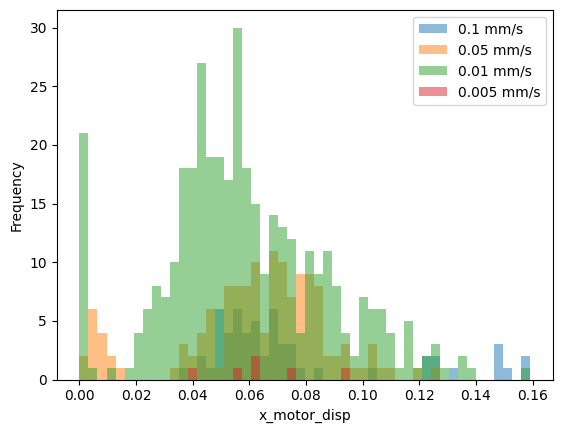

16.783514465704727
14.88152878300653
19.830966273951564


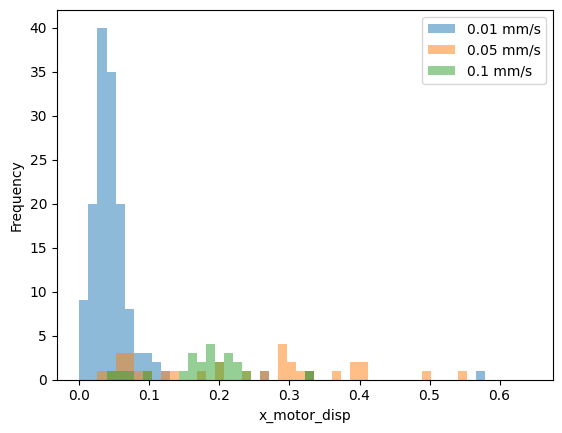

In [202]:
# plot the displacment between each stress drop
plot_histogram(jbzq04_stress_drops_1, 'x_motor_disp', True, [0.1, 0.05, 0.01, 0.005], nbins)

plot_histogram(flat_stress_drops, 'x_motor_disp', True, [0.01, 0.05, 0.1], nbins)